<a href="https://colab.research.google.com/github/gaurav1610/Audio-Classification-Using-CNN/blob/master/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5889 sha256=271d56ddb685890b53f694fce0bc49fbdacf1dd8bdf0de589db3b51b38235237
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/My Drive/Audio-Classification-master

/content/drive/My Drive/Audio-Classification-master


In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

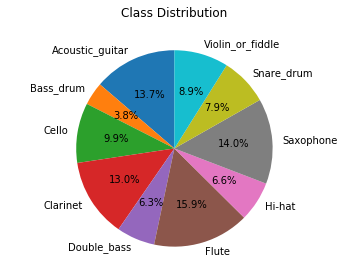

TypeError: ignored

In [10]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
def envelope(y,rate,threshold):
    mask =[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean
    for m in y_mean:
        if m > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


def calc_fft(y,rate):
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/rate)
    Y=abs(np.fft.rfft(y)/n)
    return(Y,freq)

df = pd.read_csv('instruments.csv')
df.set_index('fname',inplace=True)



for i in df.index:
    rate,signal = wavfile.read('wavfiles/'+i)
    df.at[i,'length'] = signal.shape[0]/rate

classes=list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
fig,ax=plt.subplots()
ax.set_title('Class Distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)
signals={}
fft={}
fbank={}
mfccs={}

for c in classes:
    wav_file=df[df.label ==c].iloc[0,0]
    signal,rate=librosa.load('wavfiles/'+wav_file,sr=44100)
    mask = envelope(signal,rate,0.0005)
    signal=signal[mask]
    signals[c] = signal
    fft[c]=calc_fft(signal,rate)


    bank=logfbank(signal[:rate],rate,nfilt=16,nfft=1103).T
    fbank[c] =bank
    mel =mfcc(signal[:rate],rate,numcep = 13,nfilt=26,nfft=1103)
    mfccs[c]=mel
plot_signals(signals)
plt.show()
plot_fft(fft)
plt.show()
plot_fbank(fbank)
plt.show()
plot_mfccs(mfccs)
plt.show()

if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate=librosa.load('wavfiles/'+f,sr=16000)
        mask = envelope(signal,rate,0.0005)
        wavfile.write(filename='clean/'+f,rate=rate,data=signal[mask])
